# Upload the BEANS dogs recordings to HF

#### 1. Download the recordings the way BEANS do it on their [GitHub](https://github.com/earthspecies/beans)

First we will navigate into the mounted data_birdset folder to download the temporary files from the Repo their and install wget & unzip as they are not on the university bash.

In [1]:
%cd '../../../../data_birdset/beans'
!pwd
!sudo apt install wget
!sudo apt install unzip
!yes | sudo apt install sox


/workspace/data_birdset/beans
/workspace/data_birdset/beans


/workspace/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
yes: standard output: Broken pipe


Then we will run their script to download the metadata and recordings to have the same splits.

In [7]:
# Their script:
import sys
import pandas as pd
from plumbum import local, FG
from pathlib import Path
from sklearn.model_selection import train_test_split

local['mkdir']['-p', 'data/dogs/wav']()
#local['wget']['-O', 'data/dogs/dog_barks.zip', 'https://archive.org/download/dog_barks/dog_barks.zip'] & FG
local['unzip']['data/dogs/dog_barks.zip', '-d', 'data/dogs/'] & FG

df = pd.read_csv('data/dogs/annotations.csv')

def convert(row):
    src_path = Path('data/dogs/audio') / row['filename']
    tgt_path = Path('data/dogs/wav') / (Path(row['filename']).stem + '.wav')

    print(f'Converting {src_path} ...', file=sys.stderr)

    local['sox'][src_path, '-r 44100', '-R', tgt_path]()

    new_row = pd.Series({
        'path': tgt_path,
        'label': row['name']
    })

    return new_row

df = df.apply(convert, axis=1)

df_train, df_valid_test = train_test_split(df, test_size=0.4, random_state=42, shuffle=True, stratify=df['label'])
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=42, shuffle=True, stratify=df_valid_test['label'])
df_train_low, _ = train_test_split(df_train, test_size=0.8, random_state=42, shuffle=True, stratify=df_train['label'])

df_train = df_train.sort_index()
df_train_low = df_train_low.sort_index()
df_valid = df_valid.sort_index()
df_test = df_test.sort_index()

df_train.to_csv('data/dogs/annotations.train.csv')
df_train_low.to_csv('data/dogs/annotations.train-low.csv')
df_valid.to_csv('data/dogs/annotations.valid.csv')
df_test.to_csv('data/dogs/annotations.test.csv')

Archive:  data/dogs/dog_barks.zip
  inflating: data/dogs/annotations.csv  
   creating: data/dogs/audio/
  inflating: data/dogs/audio/Rudy-2-P-2a.aif  
  inflating: data/dogs/audio/Roodie-4-P-4f.aif  
  inflating: data/dogs/audio/Zoe-4-C-3f.aif  
  inflating: data/dogs/audio/Siggy-1-C-1d.aif  
  inflating: data/dogs/audio/Mac-2-P-2d.aif  
  inflating: data/dogs/audio/Siggy-4-C-4d.aif  
  inflating: data/dogs/audio/Roodie-7-A-6.aif  
  inflating: data/dogs/audio/Farley-8-P-8.aif  
  inflating: data/dogs/audio/Roodie-1-P-1a.aif  
  inflating: data/dogs/audio/Rudy-2-P-2d.aif  
  inflating: data/dogs/audio/Mac-10-C-8a.aif  
  inflating: data/dogs/audio/Siggy-3-C-3g.aif  
  inflating: data/dogs/audio/Zoe-2-C-2c.aif  
  inflating: data/dogs/audio/Luke-A-2c.aif  
  inflating: data/dogs/audio/Roodie-8-C-8b.aif  
  inflating: data/dogs/audio/Roodie-2-C-2a.aif  
  inflating: data/dogs/audio/Louis-2-A-2b.aif  
  inflating: data/dogs/audio/Fried-1-P-1a.aif  
  inflating: data/dogs/audio/Roodie-6-P

Converting data/dogs/audio/Mac-3-A-3.aif ...
Converting data/dogs/audio/Mac-3-P-3.aif ...
Converting data/dogs/audio/Mac-2-P-2d.aif ...
Converting data/dogs/audio/Mac-2-P-2b.aif ...
Converting data/dogs/audio/Mac-2-A-2a..aif ...
Converting data/dogs/audio/Mac-2-P-2g.aif ...
Converting data/dogs/audio/Mac-2-P-2f.aif ...
Converting data/dogs/audio/Mac-2-P-2a.aif ...
Converting data/dogs/audio/Mac-2-P-2c.aif ...
Converting data/dogs/audio/Mac-2-A-2b.aif ...
Converting data/dogs/audio/Mac-2-P-2e.aif ...
Converting data/dogs/audio/Mac-8-P-8a.aif ...
Converting data/dogs/audio/Mac-8-C-6b.aif ...
Converting data/dogs/audio/Mac-8-P-8c.aif ...
Converting data/dogs/audio/Mac-8-C-6c.aif ...
Converting data/dogs/audio/Mac-8-P-8b.aif ...
Converting data/dogs/audio/Mac-8-A-8.aif ...
Converting data/dogs/audio/Mac-8-C-6a.aif ...
Converting data/dogs/audio/Mac-7-P-7b.aif ...
Converting data/dogs/audio/Mac-7-C-5a.aif ...
Converting data/dogs/audio/Mac-7-C-5b.aif ...
Converting data/dogs/audio/Mac-7-A-7

#### 2. Convert to HF format

In [8]:
from datasets import Dataset, Audio
import pandas as pd

def load_dataset(split_name):
    df = pd.read_csv(f'data/dogs/annotations.{split_name}.csv')
    dataset = Dataset.from_pandas(df)
    dataset = dataset.cast_column('path', Audio())
    return dataset

splits = ['train', 'train-low', 'valid', 'test']
datasets = {split: load_dataset(split) for split in splits}
datasets['train_low'] = datasets.pop('train-low') # Rename split from train-low to train_low as HF does not accept -
for split, dataset in datasets.items():
    #dataset.save_to_disk(f'data/dogs/{split}')
    print(dataset[0])



{'Unnamed: 0': 0, 'path': {'path': 'data/dogs/wav/Mac-3-A-3.wav', 'array': array([0.00012207, 0.00064087, 0.00010681, ..., 0.00109863, 0.00041199,
       0.00019836]), 'sampling_rate': 44100}, 'label': 'Mac'}
{'Unnamed: 0': 4, 'path': {'path': 'data/dogs/wav/Mac-2-A-2a..wav', 'array': array([-7.62939453e-05,  9.30786133e-04,  4.42504883e-04, ...,
        1.43432617e-03,  1.58691406e-03,  6.71386719e-04]), 'sampling_rate': 44100}, 'label': 'Mac'}
{'Unnamed: 0': 6, 'path': {'path': 'data/dogs/wav/Mac-2-P-2f.wav', 'array': array([0.00079346, 0.00027466, 0.00033569, ..., 0.00068665, 0.00085449,
       0.0005188 ]), 'sampling_rate': 44100}, 'label': 'Mac'}
{'Unnamed: 0': 0, 'path': {'path': 'data/dogs/wav/Mac-3-A-3.wav', 'array': array([0.00012207, 0.00064087, 0.00010681, ..., 0.00109863, 0.00041199,
       0.00019836]), 'sampling_rate': 44100}, 'label': 'Mac'}


#### 3. Upload the datasets to HF

In [9]:
for split, dataset in datasets.items():
    dataset.push_to_hub('DBD-research-group/beans_dogs', split=split)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/207 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/356 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/463 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

---
# Download the dataset from HF

Download all splits from the hub. Even when specifying a specific split it still downloads everything! Use `streaming=True` and `cache_dir='...'` for shorter loading times.

In [1]:
from datasets import load_dataset, DatasetDict

#dataset = load_dataset(path='DBD-research-group/beans_dogs', split='test')
dataset: DatasetDict = load_dataset(name='default', path='DBD-research-group/beans_dogs')

Generating train split:   0%|          | 0/415 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/139 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/139 [00:00<?, ? examples/s]

Generating train_low split:   0%|          | 0/83 [00:00<?, ? examples/s]

Now you can interact with the dataset. 

In [3]:
# print number of samples and number of distinct classes
print(f"Number of samples: {len(dataset['train'])}")
print(f"Number of distinct classes: {len(dataset['train'].unique('label'))}")
dataset

Number of samples: 415
Number of distinct classes: 10


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'path', 'label'],
        num_rows: 415
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'path', 'label'],
        num_rows: 139
    })
    test: Dataset({
        features: ['Unnamed: 0', 'path', 'label'],
        num_rows: 139
    })
    train_low: Dataset({
        features: ['Unnamed: 0', 'path', 'label'],
        num_rows: 83
    })
})

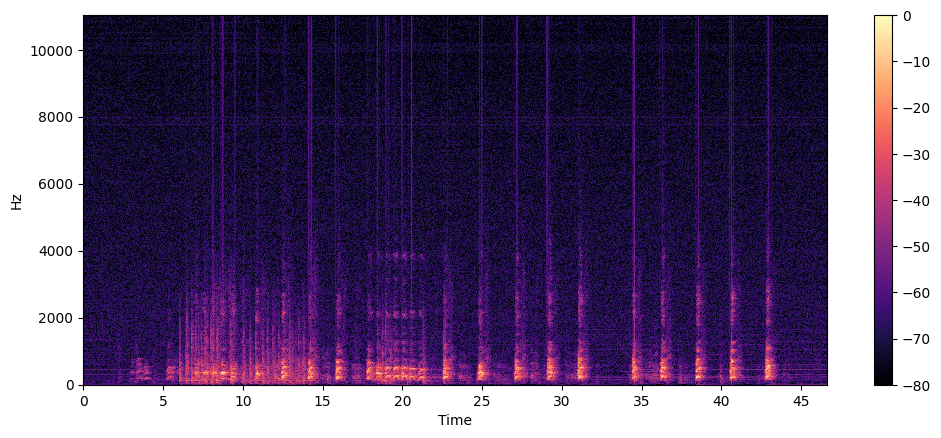

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

audio = dataset['train'][0]['path']

D = librosa.stft(audio['array'])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()